<a href="https://colab.research.google.com/github/fabiopernisi/metropolis/blob/main/metropolis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring Neural Network Training with non-zero Temperature Metropolis Algorithm

Authors: Giosuè Castellano, Fabio Pernisi, Alan Picucci.

Date: 06/06/2023

In this notebook we will expand on the work done in "Training neural networks using Metropolis Monte Carlo and an adaptive variant" by Whitelam et al. (2022), https://arxiv.org/abs/2205.07408.

The paper examines the zero-temperature Metropolis Monte Carlo algorithm as a tool for training a neural network by minimizing a loss function. In its first verision, the algorithm proposed by Whitealm and colleagues, simply adds a Gaussian random number ϵ to each weight $x_i$ in the network,

$x_i \to x_i + \epsilon_i, \quad \epsilon_i \sim N(0, \sigma^2)$

 where $\sigma^2$ is constant across weights. This proposal is accepted only if the loss does not increase (as zero-temperature Metropolis is used). This initial version of the algorithm closely reminds of the Gradient Descent algorithm for optimization.

 A second version of the algorithm (the adaptive-MonteCarlo, **aMC**) presented in the paper defines the proposed move as

 $x_i \to x_i + \epsilon_i \quad N(\mu_i, \sigma_i^2)$

where, now bot the variance and the mean of the Gaussian distribution are different for each weight. The mean $\mu_i$ is updated after every accepted move, according to

$\mu_i \to \mu_i + \epsilon(\epsilon_i - \mu_i)$

where $\epsilon$ is a hyperparameter of the model. The variance $\sigma_i$ is instead modified through the following simple adaptive learning-rate schedule. After every $n_S$ (in the code *n_reset*) consecutively rejected moves, the two following changes are implemented:

$\sigma_i \to \sigma_i \cdot 0.95$

$\mu_i = 0$

The step-size is initialized to a constatn value:

$\sigma = \sigma_0$


Our goal is to explore the non-zero-temperature version of the aMC algorithm.


##Import Data from Github

Import needed libraries:

In [ ]:
import numpy as np
import pandas as pd
import torch
import math
import torchvision
import matplotlib.pyplot as plt
import time
from torch import nn
from torch import optim
from sklearn.model_selection import ParameterGrid, KFold
from copy import deepcopy
import seaborn as sns
import matplotlib.ticker as ticker
import itertools

Next, we introduce the aMC optimizer. The code is copied from the offical github-repository containing the implementation of the model described in the paper.

In [ ]:
class aMC(torch.optim.Optimizer):
    def __init__(self, params, init_sigma, epsilon = 0., beta = "inf", n_reset = 100, sigma_decay = .95, minibatch = False):
        """
        init_sigma is the initial std deviation of the noise
        epsilon is an hyperparameter defined in equation (10) in the paper -> similar to inclusion of momentum
        beta is the inverse of the temperature
        sigma decay is the decay of the std deviation of the noise over time
        """

        defaults = dict(init_sigma = init_sigma, epsilon = epsilon, beta = beta, n_reset = n_reset, sigma_decay = sigma_decay, minibatch = minibatch)
        super().__init__(params,defaults)

        self._params = self.param_groups[0]['params']
        if len(self.param_groups) != 1:
            raise ValueError("Currently doesn't support per-parameter options "
                             "(parameter groups)")

        #initialize optimizer parameters
        # NOTE: aMC currently has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict

        state = self.state[self._params[0]]

        if not minibatch:
            state['best_loss'] = None

        state['minibatch'] = minibatch
        state['sigma'] = init_sigma
        state['n_cr'] = 0 #state["n_cr"] records the number of consecutive rejected moves.

        # set the mean of each parameter's move-prposal to zero
        state['mus'] = []
        for p in self._params:
            state['mus'].append(torch.zeros_like(p))

    def sample_noise(self):
        noise = []
        state = self.state[self._params[0]]
        for i in range(len(self._params)):
            noise.append(torch.normal(mean =  state['mus'][i], std= state['sigma']))

        return noise

    def _add_noise(self, noise):
        for i in range(len(self._params)):
            self._params[i].add_(noise[i])

    def _subtract_noise(self, noise):
        for i in range(len(self._params)):
            self._params[i].subtract_(noise[i])

    @torch.no_grad()
    def step(self, closure):

        state = self.state[self._params[0]]
        group = self.param_groups[0]

        #Calculate initial loss
        if not state['minibatch']:
            if state['best_loss'] == None:
                state['best_loss'] = closure()
            init_loss = state['best_loss']
        else:
            init_loss = closure()

        #sample noise, evaluate new loss function, and accept/reject move
        noise = self.sample_noise()

        self._add_noise(noise)

        new_loss = closure()


        move_accepted = False
        cost = new_loss - init_loss
        if cost <= 0:
            move_accepted = True
        elif group['beta'] != "inf":
            if np.random.rand() < torch.exp(-cost * group['beta']):
                #print("Move accepted by probability",cost,torch.exp(-cost * group['beta'] )) just to see when we accept this change
                move_accepted = True


        if move_accepted:
            state['n_cr'] = 0
            if not state['minibatch']:
                state['best_loss'] = new_loss

            #Shift mean based on noise
            if group['epsilon'] != 0:
                for i in range(len(self._params)):
                    state['mus'][i] += group['epsilon'] * (noise[i] - state['mus'][i])

            return new_loss

        else:
            #reset net to previous state
            self._subtract_noise(noise)
            state['n_cr'] +=1

            if state['n_cr'] == group['n_reset']:
                state['sigma'] *= group['sigma_decay']
                for i in range(len(self._params)):
                    state['mus'][i].zero_()

                state['n_cr'] = 0

            return init_loss

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("device: "+ device)


#won't need to calculate gradients anywhere, this speeds up computation
torch.autograd.set_grad_enabled(False)


#fully-connected neural network for classifying mnist
class amc_net(torch.nn.Module):
    def __init__(self, hidden_dim, num_hidden_layers, act= "tanh", layernorm = True, bias=False):
        super().__init__()


        if act == "tanh":
            act_f = torch.nn.Tanh()
        else:
            act_f = torch.nn.ReLU()

        model = []

        #input layer
        if layernorm:
            model += [torch.nn.Linear(784, hidden_dim, bias = False), torch.nn.LayerNorm(hidden_dim), act_f]
        else:
            model += [torch.nn.Linear(784, hidden_dim,bias=bias), act_f]

        #hidden layers
        for i in range(num_hidden_layers):
            if layernorm:
                model += [torch.nn.Linear(hidden_dim, hidden_dim, bias = False), torch.nn.LayerNorm(hidden_dim), act_f]
            else:
                model += [torch.nn.Linear(hidden_dim, hidden_dim,bias=bias), act_f]

        #output layer
        model += [torch.nn.Linear(hidden_dim,10,bias=bias)]

        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

#initialize weights from gaussian distribution
def init_net(net, scale, bias = False):
    for i, mod in enumerate(net.modules()):
        if isinstance(mod, torch.nn.Linear):
            torch.nn.init.normal_(mod.weight, std=scale)
            if bias:
                torch.nn.init.normal_(mod.bias, std=scale)

In the following we import the dataset MNIST which is the base for our analysis.

In [ ]:
#download training and testing data, normalize and flatten
transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ,torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ,torchvision.transforms.Lambda(torch.flatten)
    ])

training_dataset = torchvision.datasets.MNIST('data', train=True, download = True,
                    transform=transform)

testing_dataset = torchvision.datasets.MNIST('data', train=False, download = True,
                    transform=transform)


#full-batch learning, move all data to device
train_loader = torch.utils.data.DataLoader(training_dataset,batch_size = 60000)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)


for data,target in train_loader:
    train_data = data.to(device)
    train_target = target.to(device)

for data,target in test_loader:
    test_data = data.to(device)
    test_target = target.to(device)

#Vary temperature and compare results

In this section we compare how changing the hyperparameter beta affects the results. The beta stays fixed for the whole training process. We keep the number of epochs fixed at 10000 steps and record at each step the training and validation loss and the accuracy on the test set which we plot in the end.

##Functions for visualization of metropolis algorithm

In [ ]:
hidden_dim = 64
num_hidden_layers = 3

init_sigma = 1e-3
epsilon = 1e-3

model = amc_net(hidden_dim, num_hidden_layers).to(device)
init_net(model, init_sigma)
beta_values=[0,100,1000,10000,"inf"] #these are the beta values I propose to try at first
stats=[] #to keep track of all data
runtime=[]#idk interested in runtime
for i in beta_values:
  optimizer = aMC(model.parameters(), init_sigma = init_sigma, epsilon = epsilon, beta=i)

  #optimize net using aMC to classify MNIST images
  num_epochs = int(10000) #10000 iterations because I dont wanna wait forever
  train_stats = np.zeros((num_epochs, 3))

  loss_function = torch.nn.CrossEntropyLoss()
  start=time.time()
  for t in range(num_epochs):

      model.train()
      def loss_closure():
          output = model(train_data)
          loss = loss_function(output, train_target)
          return loss

      #apply mutation to net, update net if move accepted
      loss = optimizer.step(loss_closure)

      train_stats[t,0] = loss.item()


      #if model has been updated: calculate loss and accuracy on validation set
      if t ==0 or (t > 0 and train_stats[t, 0] != train_stats[t-1,0]):
          model.eval()
          output = model(test_data)
          loss = loss_function(output, test_target)
          train_stats[t,1] = loss


          pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          acc = pred.eq(test_target.view_as(pred)).sum().item()
          train_stats[t,2] = acc/test_target.shape[0]
      else:
          train_stats[t,1] = train_stats[t-1,1]
          train_stats[t,2] = train_stats[t-1,2]
  stats.append(train_stats) #append the train_stats to the list which keeps track
  end=time.time()
  runtime.append(end-start)
      #print(train_stats[t])

<ipython-input-10-bfbf3fef397e>:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


In [ ]:
runtime #runtime for each beta, notice inf is fastest because we never compute exponential and never need to change weights back to originial value on GPU T4

[88.93572449684143,
 89.2874903678894,
 88.32402539253235,
 86.07918167114258,
 83.19951510429382]

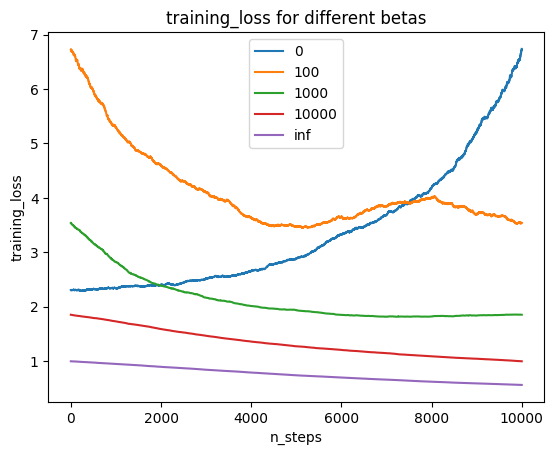

In [ ]:
for i in range(len(stats)):
  plt.plot(stats[i][:,0],label=str(beta_values[i]))
  plt.xlabel("n_steps")
  plt.ylabel("training_loss")
plt.title("training_loss for different betas")
plt.legend()
plt.show()

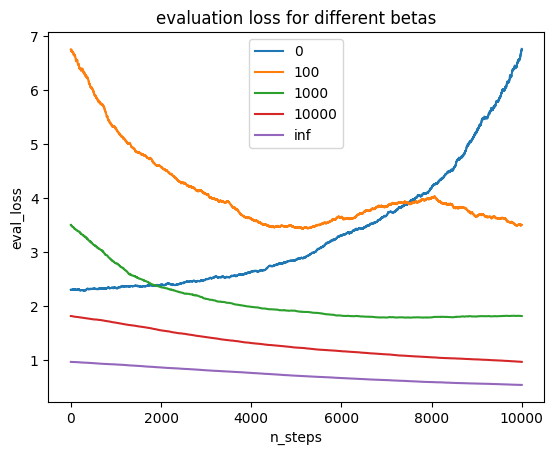

In [ ]:
for i in range(len(stats)):
  plt.plot(stats[i][:,1],label=str(beta_values[i]))
  plt.xlabel("n_steps")
  plt.ylabel("eval_loss")
plt.title("evaluation loss for different betas")
plt.legend()
plt.show()

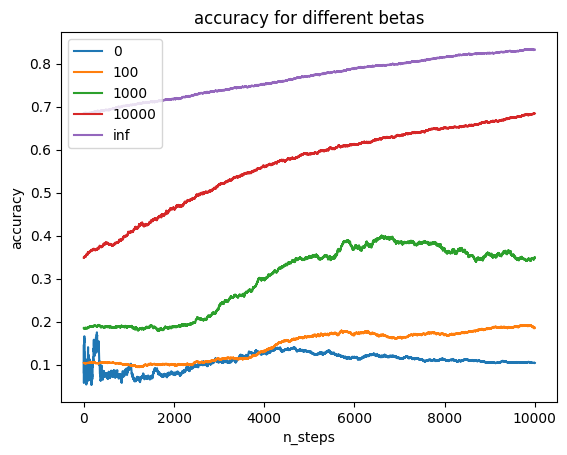

In [ ]:
for i in range(len(stats)):
  plt.plot(stats[i][:,2],label=str(beta_values[i]))
  plt.xlabel("n_steps")
  plt.ylabel("accuracy")
plt.title("accuracy for different betas")
plt.legend()
plt.show()

Here we define three functions which are used to keep track of how many moves are accepted, rejected and accepted by chance using the metropolis criterion as a function of beta:

In [ ]:
def denied(data):
  s=0
  for i in range(len(data)-1):
   if data[i]==data[i+1]:
    s+=1
  return s

In [ ]:
def accepted(data):
  s=0
  for i in range(len(data)-1):
   if data[i]>data[i+1]:
    s+=1
  return s

In [ ]:
def accepted_by_chance(data):
  s=0
  for i in range(len(data)-1):
   if data[i]<data[i+1]:
    s+=1
  return s

We now define a table to visualize the results. Notice that a beta of "Infinity" results in 0 accepted moves by chance, because the accepting probability is 0 for a move that was initially rejected. Vice versa, for a beta equal to 0 we have 0 denied steps because the probability of accepting a  initially rejected move is 1.

In [ ]:
moves=pd.DataFrame(columns=["Beta","Accepted", "Denied", "Accepted by metropolis"], index=[i for i in range(len(beta_values))])
for i in range(len(stats)):
  moves["Beta"].iloc[i]=beta_values[i]
  moves["Accepted"].iloc[i]=accepted(stats[i][:,0])
  moves["Denied"].iloc[i]=denied(stats[i][:,0])
  moves["Accepted by metropolis"].iloc[i]=accepted_by_chance(stats[i][:,0])
moves

,Beta,Accepted,Denied,Accepted by metropolis
0,0,4379,0,5620
1,100,4890,987,4122
2,1000,4791,1833,3375
3,10000,5150,3343,1506
4,inf,5312,4687,0


#Vary temperature after n_failed steps

In our second approach we propose a new method: After a certain amount of consecutively rejected moves (hyperparameter beta_reset), we increase the temperature (beta_amount). After the temperature has changed, we linearly increase the temperature (beta_increase) for every following step until it hits a certain value (beta_roof), after which it will be set to "inf" again. We also introduce a threshhold (threshhold) such that if the change in loss is less than minus that threshhold a move automatically gets accepted.

In [ ]:
class aMCT(torch.optim.Optimizer):
    def __init__(self, params,init_sigma,epsilon = 0., beta = "inf", n_reset = 100, beta_roof=100000, beta_reset=100, beta_amount=10000,beta_increase=1.5,sigma_decay = .95, threshhold=0, minibatch = False):
        """
        Explaination of parameters that we added: after beta_reset consecutive steps where we don't accept a move we change beta.
        beta_amount is the value of beta we change to after beta_reset consecutive steps with no accepted move.
        After changing to beta_amount it gets increased at each step according to the formula: beta = beta_increase * beta
        threshhold is the threshhold for which we accept moves according to the formula: cost <= - threshhold is an accepted move
        """


        defaults = dict(init_sigma = init_sigma, epsilon = epsilon, beta = beta, n_reset = n_reset ,beta_roof=beta_roof,threshhold=threshhold,sigma_decay = sigma_decay, minibatch = minibatch,beta_reset=beta_reset,beta_amount=beta_amount,beta_increase=beta_increase)
        super().__init__(params,defaults)
        self.changedtemp=False
        self.temploss=0
        self._params = self.param_groups[0]['params']
        if len(self.param_groups) != 1:
            raise ValueError("Currently doesn't support per-parameter options "
                             "(parameter groups)")

        #initialize optimizer parameters

        # NOTE: aMC currently has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]

        if not minibatch:
            state['best_loss'] = None

        state['minibatch'] = minibatch
        state['sigma'] = init_sigma
        state['n_cr'] = 0
        state['mus'] = []
        for p in self._params:
            state['mus'].append(torch.zeros_like(p))

    def sample_noise(self):
        noise = []
        state = self.state[self._params[0]]
        for i in range(len(self._params)):
            noise.append(torch.normal(mean =  state['mus'][i], std= state['sigma']))

        return noise

    def _add_noise(self, noise):
        for i in range(len(self._params)):
            self._params[i].add_(noise[i])

    def _subtract_noise(self, noise):
        for i in range(len(self._params)):
            self._params[i].subtract_(noise[i])

    @torch.no_grad()
    def step(self, closure):

        state = self.state[self._params[0]]
        group = self.param_groups[0]

        #Calculate initial loss
        if not state['minibatch']:
            if state['best_loss'] == None:
                state['best_loss'] = closure()
            init_loss = state['best_loss']
        else:
            init_loss = closure()

        #sample noise, evaluate new loss function, and accept/reject move
        noise = self.sample_noise()

        self._add_noise(noise)

        new_loss = closure()

        move_accepted = False
        cost = new_loss - init_loss
        if self.changedtemp==True:
            group['beta']=group['beta_increase']*group['beta']
            if group['beta']>group['beta_roof']:
              group['beta']='inf'
              self.changedtemp=False
            if (new_loss - self.temploss)<= -group['threshhold']:
              group['beta']='inf'
              self.changedtemp=False

        if cost <= -group['threshhold']:
            move_accepted = True
        elif group['beta'] != "inf":
            if np.random.rand() < torch.exp(-cost * group['beta']):
                move_accepted = True

        if move_accepted:
            # if state['sigma']>1e-5:
            #   state['sigma'] *= group['sigma_decay']
            state['n_cr'] = 0
            if not state['minibatch']:
                state['best_loss'] = new_loss

            #Shift mean based on noise
            if group['epsilon'] != 0:
                for i in range(len(self._params)):
                    state['mus'][i] += group['epsilon'] * (noise[i] - state['mus'][i])

            return new_loss

        else:
            #reset net to previous state
            self._subtract_noise(noise)
            state['n_cr'] +=1

            if state['n_cr'] == group['n_reset']:
                state['sigma'] *= group['sigma_decay']
                for i in range(len(self._params)):
                     state['mus'][i].zero_()

            if state['n_cr'] == group['beta_reset']:
              group['beta']=group['beta_amount']
              self.changedtemp=True
              state['n_cr']=0
              self.temploss=init_loss

            return init_loss

In [ ]:
#initialize neural network and optimizer
hidden_dim = 64
num_hidden_layers = 3

init_sigma = 1e-3
epsilon = 1e-3

model = amc_net(hidden_dim, num_hidden_layers).to(device)
init_net(model, init_sigma)

optimizer = aMCT(model.parameters(), init_sigma = init_sigma, epsilon = epsilon, beta='inf', beta_reset=10,threshhold=0)

#optimize net using aMC to classify MNIST digits
num_epochs = int(10000)
train_stats = np.zeros((num_epochs, 3))

loss_function = torch.nn.CrossEntropyLoss()

def loss_closure():
    output = model(train_data)
    loss = loss_function(output, train_target)
    return loss

for t in range(num_epochs):
    model.train()

    #apply mutation to net, update net if move accepted
    loss = optimizer.step(loss_closure)

    train_stats[t,0] = loss.item()

    #if model has been updated: calculate loss and accuracy on validation set
    if t ==0 or (t > 0 and train_stats[t, 0] != train_stats[t-1,0]):
        model.eval()
        output = model(test_data)
        loss = loss_function(output, test_target)
        train_stats[t,1] = loss
        pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        acc = pred.eq(test_target.view_as(pred)).sum().item()
        train_stats[t,2] = acc/test_target.shape[0]
    else:
        train_stats[t,1] = train_stats[t-1,1]
        train_stats[t,2] = train_stats[t-1,2]

<ipython-input-25-01524b65f043>:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


##Hyperparameters Optimization


Next up we define four functions to simplify the process of creating an optimizer and a model, as well as training that model for given hyperparameters and evaluating a model for RandomSearch.

In [ ]:
def create_optimizer(model,init_sigma,temperature_variation=True, epsilon=0.,beta_roof=100000, beta='inf',n_reset=100, beta_reset=10, beta_amount=10000, beta_increase=1.5, sigma_decay=.95, threshhold=0, minibatch=False):
  """
  Create a torch optimizer.
  Parameters are the following: temperature variation is set to True if we want to use our own built function that jumps in temperature, the rest of the parameters are used by the optimizer
  """
  model=model
  if temperature_variation==True:
    optimizer = aMCT(model.parameters(), init_sigma = init_sigma, epsilon = epsilon,beta_roof=beta_roof, beta=beta,n_reset=n_reset, beta_amount=beta_amount, beta_increase=beta_increase, beta_reset=beta_reset,threshhold=threshhold, minibatch=minibatch)
    return optimizer
  else:
    optimizer = aMC(model.parameters(), init_sigma = init_sigma, epsilon = epsilon, beta=beta, sigma_decay=sigma_decay, n_reset=n_reset, minibatch=minibatch)
    return optimizer


In [ ]:
def create_model(init_sigma,hidden_dim=64, num_hidden_layers=3, activation='tanh', layernorm=True, bias=False):
    """
    Create a model with the given hidden_dims, number of hidden layers, activation function and layernorm. We also need to specify the same init_sigma as for the optimizer.
    """

    model=amc_net(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers, act=activation, layernorm=layernorm,bias=bias).to(device)
    init_net(model, init_sigma)
    return model

In [ ]:
def train_model(optimizer, model, num_epochs):
  """
  run the model for num_epochs steps. At each step the training loss, evaluation loss and accuracy is recorded in the respective order.
  """
  train_stats = np.zeros((num_epochs, 3))
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer=optimizer
  states=[]

  for t in range(num_epochs):
      states.append(deepcopy(model.state_dict()))
      model.train()
      def loss_closure():
          output = model(train_data)
          loss = loss_function(output, train_target)
          return loss

      #apply mutation to net, update net if move accepted
      loss = optimizer.step(loss_closure)

      train_stats[t,0] = loss.item()


      #if model has been updated: calculate loss and accuracy on validation set
      if t ==0 or (t > 0 and train_stats[t, 0] != train_stats[t-1,0]):
          model.eval()
          output = model(test_data)
          loss = loss_function(output, test_target)
          train_stats[t,1] = loss


          pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          acc = pred.eq(test_target.view_as(pred)).sum().item()
          train_stats[t,2] = acc/test_target.shape[0]
      else:
          train_stats[t,1] = train_stats[t-1,1]
          train_stats[t,2] = train_stats[t-1,2]
  return train_stats, states

In [ ]:
def evaluate_model(optimizer, model, num_epochs, X_train, Y_train, X_test, Y_test):
  """
  run the model for num_epochs steps. At each step the training loss, evaluation loss and accuracy is recorded in the respective order.
  X_train, Y_train, X_test and Y_test will be our cross-validation sets.
  """
  train_stats = np.zeros((num_epochs, 3))
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer=optimizer
  states=[]

  for t in range(num_epochs):
      states.append(deepcopy(model.state_dict()))
      model.train()
      def loss_closure():
          output = model(X_train)  # use the train data from the fold
          loss = loss_function(output, Y_train)  # use the train target from the fold
          return loss

      #apply mutation to net, update net if move accepted
      loss = optimizer.step(loss_closure)

      train_stats[t,0] = loss.item()


      #if model has been updated: calculate loss and accuracy on validation set
      if t ==0 or (t > 0 and train_stats[t, 0] != train_stats[t-1,0]):
          model.eval()
          output = model(X_test)  # use the test data from the fold
          loss = loss_function(output, Y_test)  # use the test target from the fold
          train_stats[t,1] = loss

          pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          acc = pred.eq(Y_test.view_as(pred)).sum().item()  # use the test target from the fold
          train_stats[t,2] = acc/Y_test.shape[0]
      else:
          train_stats[t,1] = train_stats[t-1,1]
          train_stats[t,2] = train_stats[t-1,2]
  return train_stats, states

##RandomSearch

For a given set of fixed hyperparameters hidden_dim, num_hidden_layers, init_sigma and epsilon we try to find an optimal set of the hyperparameters which we introduced before: beta_amount, beta_reset, beta_increase and beta_roof.
We use np.arange to create a dictionary of values taken by the parameters. Then we choose a value randomly using np.random.choice for each parameter and make sure that this combination can not be used again. After this we evaluate the model for a given number of steps (num_epochs) and return the best performing one.

In [ ]:
hidden_dim = 64
num_hidden_layers = 3

init_sigma = 1e-3
epsilon = 1e-3

In [ ]:
np.random.seed(42)

In [ ]:
def grid_search(param_grid, num_epochs, n_searches=10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  grid = ParameterGrid(param_grid)
  best_accuracy = 0
  best_params = None
  best_result= None

  # Create the KFold object
  kf = KFold(n_splits=3, shuffle=True)

  for params in np.random.choice(grid, n_searches, replace=False):
    accuracies = []  # We will store the accuracy for each fold here

    for train_index, test_index in kf.split(train_data):
      # Split the data
      X_train_fold, X_test_fold = train_data[train_index], train_data[test_index]
      Y_train_fold, Y_test_fold = train_target[train_index], train_target[test_index]

      model=create_model(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers, init_sigma=init_sigma, activation="tanh")
      opt_temp=create_optimizer(model=model,init_sigma=init_sigma, epsilon=epsilon, temperature_variation=True,beta_roof=params['beta_roof'], beta_reset=params['beta_reset'], beta_amount=params['beta_amount'], beta_increase=params['beta_increase'])

      # Pass the folds to the evaluate_model function
      result_temp, idc=evaluate_model(model=model, optimizer=opt_temp, num_epochs=num_epochs, X_train=X_train_fold, Y_train=Y_train_fold, X_test=X_test_fold, Y_test=Y_test_fold)
      accuracies.append(result_temp[-1,2])
      print(f"Finished training with parameters: {params}, accuracy: {result_temp[-1,2]}, evaluation_loss: {result_temp[-1,1]}")

    mean_accuracy = np.mean(accuracies)
    if mean_accuracy > best_accuracy:
      best_accuracy = mean_accuracy
      best_params = params
      best_result = result_temp

  print(f"Best parameters found: {best_params}, with Accuracy: {best_accuracy}")
  return best_params, result_temp

In [ ]:
grid = {"beta_amount": np.arange(1000,100000,1000), "beta_reset": np.arange(5,40,1), "beta_increase": np.arange(1,3,0.1), "beta_roof": np.arange(100000,400000,50000)}

In [ ]:
best_params, result_temp=grid_search(param_grid=grid, num_epochs=5000, n_searches=10)

<ipython-input-44-e968411cbf1e>:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


Finished training with parameters: {'beta_amount': 76000, 'beta_increase': 2.8000000000000016, 'beta_reset': 38, 'beta_roof': 150000}, accuracy: 0.70365, evaluation_loss: 1.0548299551010132
Finished training with parameters: {'beta_amount': 76000, 'beta_increase': 2.8000000000000016, 'beta_reset': 38, 'beta_roof': 150000}, accuracy: 0.72535, evaluation_loss: 1.0250622034072876
Finished training with parameters: {'beta_amount': 76000, 'beta_increase': 2.8000000000000016, 'beta_reset': 38, 'beta_roof': 150000}, accuracy: 0.7046, evaluation_loss: 1.084093689918518
Finished training with parameters: {'beta_amount': 51000, 'beta_increase': 2.000000000000001, 'beta_reset': 15, 'beta_roof': 150000}, accuracy: 0.7002, evaluation_loss: 1.0578460693359375
Finished training with parameters: {'beta_amount': 51000, 'beta_increase': 2.000000000000001, 'beta_reset': 15, 'beta_roof': 150000}, accuracy: 0.74735, evaluation_loss: 0.9821212887763977
Finished training with parameters: {'beta_amount': 5100

After doing a 3-fold cross validation of the parameters for 10 searches (different sets of hyperparameters) we found the following best-performing ones:
beta_amount=51000, beta_increase=2.5, beta_reset=21, beta_roof=300000.

##Comparison between models

In [ ]:
num_epochs = 10000

Create results for the original model (amc):

In [ ]:
model=create_model(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers, init_sigma=init_sigma, activation="tanh")
opt=create_optimizer(model=model,init_sigma=init_sigma, epsilon=epsilon, temperature_variation=False)
result, states=train_model(model=model, optimizer=opt, num_epochs=num_epochs)

<ipython-input-49-4691bd815254>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


Create results for our own model (amcT):

In [ ]:
model=create_model(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers, init_sigma=init_sigma, activation="tanh")
opt_temp=create_optimizer(model=model,init_sigma=init_sigma, epsilon=epsilon, temperature_variation=True, beta_reset=21, beta_amount=51000, beta_increase=2.5, beta_roof=350000)
result_temp2,states=train_model(model=model, optimizer=opt_temp, num_epochs=num_epochs)

<ipython-input-49-4691bd815254>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


Lets look at the performance of the obtained model after random search (amcT) in comparison to the original model (amc):

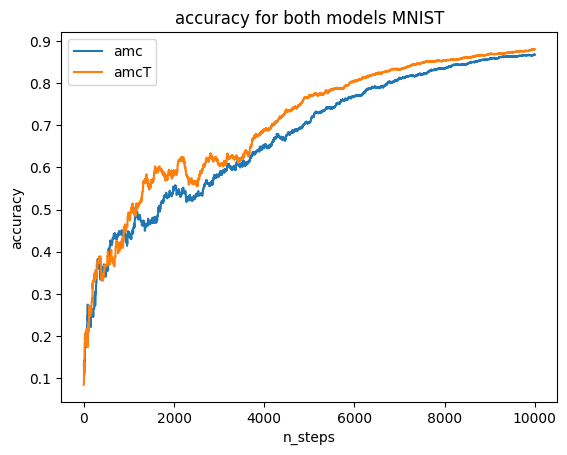

In [ ]:
plt.plot(result[:,2],label="amc")
plt.plot(result_temp2[:,2],label="amcT")
plt.xlabel("n_steps")
plt.ylabel("accuracy")
plt.title("accuracy for both models MNIST")
plt.legend()
plt.show()

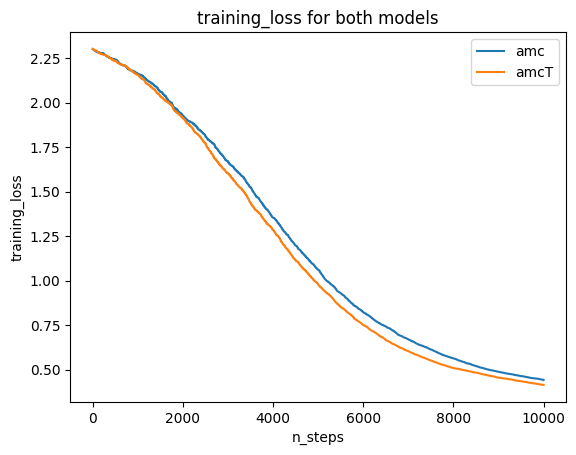

In [ ]:
plt.plot(result[:,0],label="amc")
plt.plot(result_temp2[:,0],label="amcT")
plt.xlabel("n_steps")
plt.ylabel("training_loss")
plt.title("training_loss for both models")
plt.legend()
plt.show()

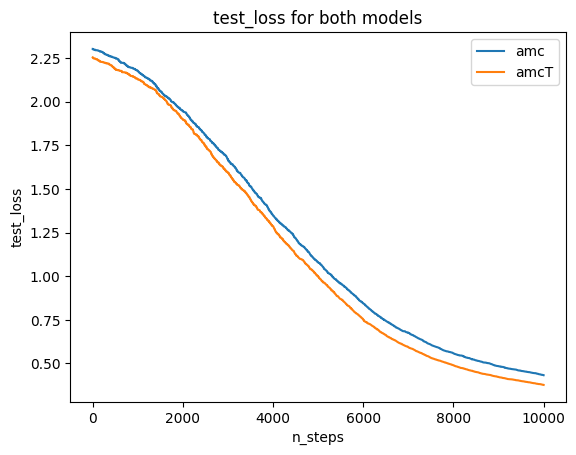

In [ ]:
plt.plot(result[:,1],label="amc")
plt.plot(result_temp2[:,1],label="amcT")
plt.xlabel("n_steps")
plt.ylabel("test_loss")
plt.title("test_loss for both models")
plt.legend()
plt.show()

The following plot shows the performance of our model after doing a smaller random search (5000 epochs):

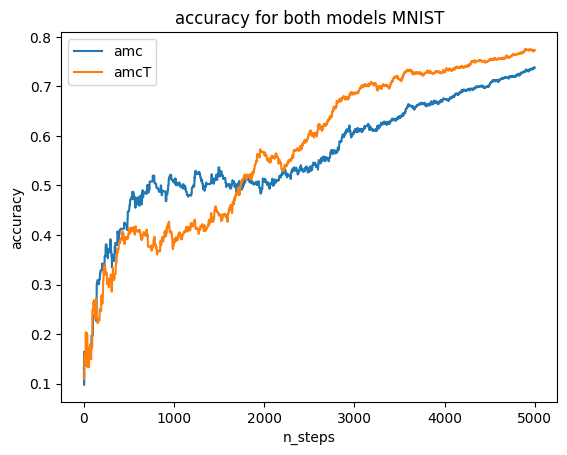

In [ ]:
plt.plot(result[:,2],label="amc")
plt.plot(result_temp[:,2],label="amcT")
plt.xlabel("n_steps")
plt.ylabel("accuracy")
plt.title("accuracy for both models MNIST")
plt.legend()
plt.show()


The following shows the difference in accuracy at the last step, result is for amc and result_temp is for amcT:

In [ ]:
result[-1,2]

0.7381

In [ ]:
result_temp[-1,2]

0.7733

#Similarity of the weights

In this section we will analyze the similarity of each set of parameters in the neural network over its epochs. We define a function to compare two state dicts of a model. A state dict contains the weights for each hidden layer. For a given layer and its matrix $W$ we compare weight $w_{ij}$ at Epoch $E_k$ with $w_{ij}$ at every following epoch $E_l$ (l>k). We first look at a single layer and its weight matrix $W$. Suppose its size is $MxM$, then our distance for that layer is $1/M^2*abs(W^k_i-W^l_i)$.

The function weight_similarity computes a normalized similarity score between two PyTorch state dictionaries, state_dict1 and state_dict2, that represent the same model architecture at two different epochs.

This comparison is done layer-by-layer, where the mean absolute difference of weights for each corresponding layer is calculated ($L1$-norm). Then, an average of these differences is computed over all the layers. Finally, the negative of this value is returned, serving as a similarity score (more negative implies less similar).

Let's denote:

The state dictionaries as $D_1$ and $D_2$.

The individual layers as $L_1^i$, $L_2^i$ where $i$ denotes the $i$-th layer.

The mean absolute difference between layers $i$ of $D_1$ and $D_2$ as $d_i = \frac{1}{n}\sum_{j=1}^{n}\left|L_1^{i,j} - L_2^{i,j}\right|$, where $L_1^{i,j}$ and $L_2^{i,j}$ are the $j$-th weights in the $i$-th layer of $D_1$ and $D_2$, respectively, and $n$ is the total number of weights in the $i$-th layer.
The total number of layers in the dictionaries as $m$.

The function essentially calculates:
$S(D_1,D_2)=-\frac{\sum_{i=1}^m d_i}{m+ϵ}$, where $\epsilon$ ensures that we do not divide by 0.

In [ ]:
def weight_similarity(state_dict1,state_dict2):
  dis=[]
  epsilon=0.001
  for layers in state_dict1:
    dis.append(abs(state_dict1[layers]-state_dict2[layers]).mean())
  return -((sum(dis)/(len(dis)+epsilon)).item())

The following print showcases the structure of a PyTorch state_dict:

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
model.0.weight 	 torch.Size([64, 784])
model.2.weight 	 torch.Size([64, 64])
model.4.weight 	 torch.Size([64, 64])
model.6.weight 	 torch.Size([64, 64])
model.8.weight 	 torch.Size([10, 64])


In [ ]:
num_epochs=1000

The variable that keeps track of the states of the amc model is called states, while the variable that keeps track of the states of the amcT model is called states2.

In [ ]:
model=create_model(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers,layernorm=False, init_sigma=init_sigma, activation="tanh")
opt=create_optimizer(model=model,init_sigma=init_sigma, epsilon=epsilon, temperature_variation=False)
result, states=train_model(model=model, optimizer=opt, num_epochs=num_epochs)

<ipython-input-49-4691bd815254>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


In [ ]:
model=create_model(hidden_dim=hidden_dim, num_hidden_layers=num_hidden_layers, init_sigma=init_sigma, activation="tanh")
opt_temp=create_optimizer(model=model,init_sigma=init_sigma, epsilon=epsilon, temperature_variation=True, beta_reset=21, beta_amount=51000, beta_increase=2.5, beta_roof=350000)
result_temp2,states2=train_model(model=model, optimizer=opt_temp, num_epochs=num_epochs)

<ipython-input-49-4691bd815254>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.nn.functional.log_softmax(output).argmax(dim=1, keepdim=True)  # get the index of the max log-probability


After computing the weight_similiarity for each pair of epochs, we then normalize the values to be between 0 and 1 and plot them in a histogram using a bin size of 0.05. The fist plot shows the results of the first model (amc) and the second plot the results of our own model (amcT).

-2.1441811867695115e-11
-0.021188989281654358


[Text(0.5, 0, 'q'), Text(0, 0.5, 'p(q)')]

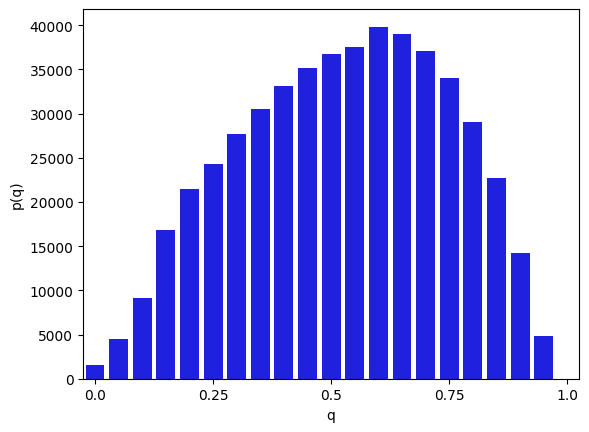

In [ ]:
qbin = 0.05

q_histo = np.zeros( int(1./qbin)+1 )
sim=[]
pairs=list(itertools.combinations(states,2))
for tuples in pairs:

      iq = weight_similarity(tuples[0],tuples[1])
      sim.append(iq)
min_val = min(sim)
max_val = max(sim)
normalized=[(x - min_val) / (max_val - min_val) for x in sim]
for value in normalized:
    iq=int(value/qbin)
    q_histo[iq] = q_histo[iq] + 1



plot = sns.barplot( x = np.arange(0,1+qbin,qbin), y=q_histo, color="blue" )
plot.xaxis.set_major_locator(ticker.MultipleLocator(5))
plot.set(xlabel='q', ylabel='p(q)')

-1.2388814800423642e-11
-0.010503883473575115


[Text(0.5, 0, 'q'), Text(0, 0.5, 'p(q)')]

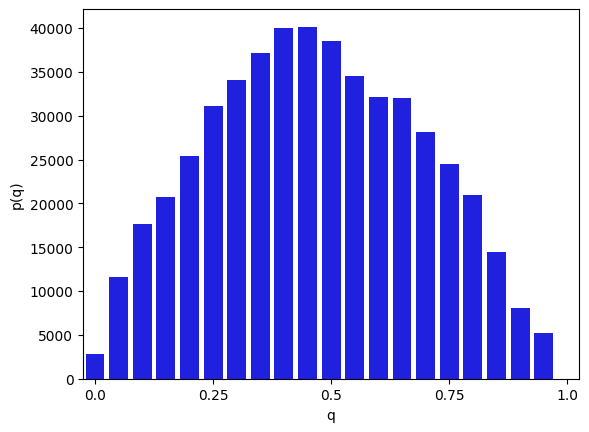

In [ ]:
qbin = 0.05

q_histo = np.zeros( int(1./qbin)+1 )
sim=[]
pairs=list(itertools.combinations(states2,2))
for tuples in pairs:

      iq = weight_similarity(tuples[0],tuples[1])
      sim.append(iq)
min_val = min(sim)
max_val = max(sim)
normalized=[(x - min_val) / (max_val - min_val) for x in sim]
for value in normalized:
    iq=int(value/qbin)
    q_histo[iq] = q_histo[iq] + 1

plot = sns.barplot( x = np.arange(0,1+qbin,qbin), y=q_histo, color="blue" )
plot.xaxis.set_major_locator(ticker.MultipleLocator(5))
plot.set(xlabel='q', ylabel='p(q)')

As one can see from the plots the amcT model has a peak at a lower similiarity value than the amc model. This means that our model changes weights to a larger extent on average and therefore explores the optimization landscape in a more thorough and extensive way.